# Variational Autoencoder
In this notebook, we demonstrate the use of a Variational Autoencoder (VAE) to model and analyze a dataset of small molecules. VAEs are a type of generative model that can learn a compressed representation of data and generate new samples that resemble the training data. This makes them particularly useful for working with molecules, where understanding the underlying distribution and generating new molecular structures can be valuable tasks in molecular design.

We will use a dataset of ~7K small molecules [../data/small_mols.csv](../data/small_mols.csv) to train our variational autoencoder.

To run this notebook, you will need to use a kernel with the following libraries installed:
* RDKit
* Pandas
* ipykernel

## Building a model
We will begin by defining a new model class called `MolecularVAE`:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        # Define the layers used in the encoder
        self.conv_1 = nn.Conv1d(35, 20, kernel_size=5)
        self.conv_2 = nn.Conv1d(20, 15, kernel_size=5)
        self.conv_3 = nn.Conv1d(15, 9, kernel_size=5)
        self.linear_0 = nn.Linear(90, 100)
        self.linear_1 = nn.Linear(100, 100)
        self.linear_2 = nn.Linear(100, 100)

        # Define the layers used in the decoder
        self.linear_3 = nn.Linear(100, 100)
        self.gru = nn.GRU(100, 200, 3, batch_first=True)
        self.linear_4 = nn.Linear(200, 22)

        # Define activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    # Encoder function
    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    # Decoder function
    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 35, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

	# Sampling function for the latent space
    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    # Forward pass of the model
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

We also need to define a function for encoding SMILES string as one-hot vectors, and a loss function. Here, we will use the binary cross-entropy (BCE) loss.

In [46]:
import numpy as np

# Function to convert SMILES strings to one-hot encodings
def smiles_to_hot(smiles, max_len, char_indices, nchars):
    X = np.zeros((len(smiles), max_len, nchars), dtype=np.float32)
    for i, smile in enumerate(smiles):
        for t, char in enumerate(smile):
            X[i, t, char_indices[char]] = 1
    return X

# Function to calculate the VAE loss using the BCE
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

## Preparing the data

In [86]:
# Preprocess the SMILES strings
all_chars = []
max_len = 35

file_path = '../data/smiles.txt'
smiles_strings = []
with open(file_path, "r") as file:
    smiles_strings_with_newlines = file.readlines()
    smiles_strings = [smi[:-1] for smi in smiles_strings_with_newlines]

for smi in smiles_strings:
    characters = [char for char in smi]
    all_chars.append(characters)

# Define the character indices for one-hot encoding
char_indices = {'S':0, '2':1, 'O':2, '[':3, 'o':4, '\\':5, 'c':6, '3':7, 'C':8, ')':9, 's':10, 'N':11, '(':12, 'H':13, ']':14, '#':15, 'n':16, '1':17, '@':18, '/':19, '=':20, ' ':21}

# Convert SMILES strings to one-hot encodings
one_hot_embeddings = smiles_to_hot(all_chars, max_len, char_indices, 22)
print(one_hot_embeddings.shape)

# Split the data into train and test datasets
data_train = one_hot_embeddings[:6000]
smiles_train = smiles_strings[:6000]
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))

data_test = one_hot_embeddings[6000:]
smiles_test = smiles_strings[6000:]
data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))

(7165, 35, 22)


## Training the model
Below we will train the VAE for 100 training epochs using a batch size of 100 and learning rate of 0.0001.

Depending on your computer, this may take about 10 minutes or so. If you don't want to wait that long, reduce the number of training epochs and continue with the analysis; the model may not be as good in that case, but you should still be able to get some insights.

In [ ]:
import torch.optim as optim

# Define training parameters
batch_size = 50
num_epochs = 100
learning_rate = 0.0001

# Create a dataloader for the train split
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

# Create an instance of the MolecularVAE model
model = MolecularVAE()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train_losses = []  # For storing the train loss per epoch
test_losses = []  # For storing the test loss per epoch

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0]

        optimizer.zero_grad()   # Zero the gradients at the start of each mini-batch

        output, mean, logvar = model(data)
        loss = vae_loss(output, data, mean, logvar)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    # Store the training loss after each epoch
    train_losses.append(train_loss / len(train_loader.dataset))

    # Save the model after each epoch
    file_path = "VAEmodel.pth"
    torch.save(model.state_dict(), file_path)

    # Compute and store the test loss after each epoch
    model.eval()
    with torch.no_grad():
        output_test, mean_test, logvar_test = model(data_test[:][0])
        test_loss = vae_loss(output_test, data_test[:][0], mean_test, logvar_test)
        test_losses.append(test_loss.item() / len(data_test))

    # Print progress
    lr = scheduler.get_lr()[0]
    print(f'Epoch {epoch}  Learning Rate: {lr:3e}  Train Loss: {train_losses[-1]:3f}  Test Loss: {test_losses[-1]:3f}')

## Analysis and best practices
Let's begin by visualizing the loss curves:

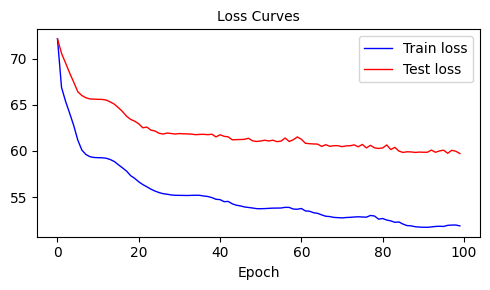

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))

ax = fig.add_subplot(1, 1, 1)

# Plot the loss as a function of the number of training epochs
ax.plot(train_losses, color='blue', lw=1, label='Train loss')
ax.plot(test_losses, color='red', lw=1, label='Test loss')
ax.set_xlabel('Epoch', size=10)
ax.set_title('Loss Curves', size=10)
ax.legend(fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()

plt.show()

### SMILES reconstruction
Next, let's analyze how well our model can reconstruct SMILES strings from the test set. 

First, we will compute the reconstruction loss for the test set and compare to the training set.

In [8]:
# Create a dataloader for the test split
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True)

# Calculate reconstruction loss on test data and compare to train data
model.eval()
with torch.no_grad():
    test_loss = 0
    for batch_idx, data in enumerate(test_loader):
        data = data[0]

        output, mean, logvar = model(data)
        loss = vae_loss(output, data, mean, logvar)

        test_loss += loss.item()

print(f'Train loss after {epoch + 1} training epochs: {train_loss / len(train_loader.dataset):.3f}')
print(f'Test loss after {epoch + 1} training epochs: {test_loss / len(test_loader.dataset):.3f}')

/Users/rocom/opt/anaconda3/envs/nb1-env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train loss after 100 training epochs: 51.866
Test loss after 100 training epochs: 59.672


The model appears to be a little overfit, but that should not be a huge issue here.


To see what the SMILES look like, we will define a function for 'decoding' the VAE output embeddings into SMILES, and look at a few SMILES from the training and test sets in detail to see how good the model is at reconstructing them.

In [47]:
# Define a function to convert VAE output embeddings 'back' to SMILES strings
def emb_to_smiles(embedding, indices_char):
    smiles = []
    for one_hot in embedding:
        smiles_chars = []
        for vector in one_hot:
            if int(torch.sum(vector)) == 0:
                continue  # Skip padding
            char_index = int(torch.argmax(vector))
            char = indices_char[char_index]
            smiles_chars.append(char)
        smiles.append(''.join(smiles_chars).strip())
    return smiles

# Define the character indices for one-hot encoding
indices_char = {v: k for k, v in char_indices.items()}
print(indices_char)

{0: 'S', 1: '2', 2: 'O', 3: '[', 4: 'o', 5: '\\', 6: 'c', 7: '3', 8: 'C', 9: ')', 10: 's', 11: 'N', 12: '(', 13: 'H', 14: ']', 15: '#', 16: 'n', 17: '1', 18: '@', 19: '/', 20: '=', 21: ' '}


In [87]:
# Let's visualize the reconstructions for the first five training and test set SMILES
model.eval()
with torch.no_grad():
    train_embeddings, _, _ = model(data_train[:5][0])
    test_embeddings, _, _ = model(data_test[:5][0])


# Decode the one-hot encoded SMILES to see how they are deconstructed
decoded_train_smiles = emb_to_smiles(train_embeddings, indices_char)
print('Training set SMILES reconstruction:')
for i, smiles in enumerate(decoded_train_smiles):
	print(f'True: {smiles_train[i]}  Reconstructed: {smiles}')

print(' ')

decoded_test_smiles = emb_to_smiles(test_embeddings, indices_char)
print('Testing set SMILES reconstruction:')
for i, smiles in enumerate(decoded_test_smiles):
	print(f'True: {smiles_test[i]}  Reconstructed: {smiles}')

Training set SMILES reconstruction:
True: C  Reconstructed: CC@H]1[CC@H1CCC22]][HHHH
True: CC  Reconstructed: CCC[@H]C)CH]12]]]cccccc
True: C=C  Reconstructed: CCH]1CC@]12]]]]cccccc
True: C#C  Reconstructed: CCC[@@](C)CH12222]]]cccc
True: CCO  Reconstructed: CCC[C@H]1CC]C22]]cccc
 
Testing set SMILES reconstruction:
True: O[C@H]1C=CNC1=O  Reconstructed: [@]CCCCCC]11OOc))
True: O[C@H]1CCNC1=O  Reconstructed: C@H]1CCC1]122]]O)
True: OC1=CC=[N]=C[CH]1  Reconstructed: CCCCCCC]COH]]]]]]]]]]]
True: OC1CCNCC1  Reconstructed: CCCCCCC11]]]HHH]]]]]]]
True: C[C@H]1CCCN1C  Reconstructed: [C@H]1CCCCCCC1122O])


💡 Note that as the model is a VAE, the reconstructed SMILES may look different each time, especially if the model is not converged.

### Latent space visualization
We can also explore the latent space between two molecules by interpolating between their latent vectors.

Let's start by visualizing the latent space using PCA, as in the [Dimensionality Reduction](../2-Dimensionality-Reduction/Dimensionality-Reduction.ipynb) notebook.

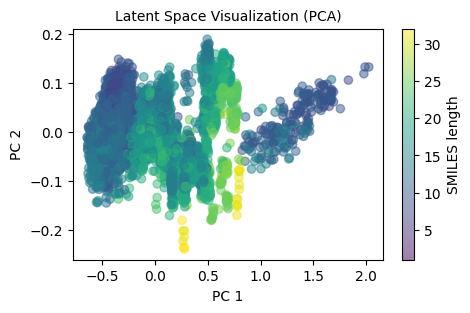

In [88]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

_, z_mean, z_logvar = model(data_train[:][0])

latent_space = z_mean.detach().numpy()

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_space)

# Plot the latent space and color points according to SMILES length
plt.figure(figsize=(5,3))

plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=[len(smiles) for smiles in smiles_train])
plt.colorbar(label='SMILES length')
plt.title('Latent Space Visualization (PCA)', size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

plt.show()

### Latent space interpolation
Now, let's try interpolating between two points in the latent space of our VAE.

💡 Note that the latent space learned by a VAE is typically not linear, but rather a non-linear manifold embedded in a higher-dimensional space. This means that linear interpolation between two points in the latent space may traverse regions that do not necessarily correspond to valid data points. For more meaningful interpolations, try spherical linear interpolation (Slerp) instead of linear interpolations.

In [89]:
# Define a spherical linear interpolation function; `midpoint` ranges from 0 (closer to `p1`) to 1 (closer to `p2`)
def slerp(p1, p2, n_inbetween_points=10):
    p1, p2 = torch.tensor(p1), torch.tensor(p2)
    interpolations = []
    for midpoint in np.linspace(0, 1, num=n_inbetween_points):
        omega = torch.acos(torch.clamp(torch.dot(p1 / torch.norm(p1), p2 / torch.norm(p2)), -1, 1))
        so = torch.sin(omega)
        if so == 0:
            interpolations.append((1.0 - midpoint) * p1 + midpoint * p2)  # L'Hopital's rule/LERP
            continue  # Avoid appending twice in case of L'Hopital's rule
        interpolations.append(torch.sin((1.0 - midpoint) * omega) / so * p1 + torch.sin(midpoint * omega) / so * p2)
    return torch.stack(interpolations)

# If you are curious about the differences between linear and Slerp interpolation, try
# interpolating with the function below instead of the slerp function
# def linear_interpolation(point1, point2, n_inbetween_points=10):
#     ratios = np.linspace(0, 1, num=n_inbetween_points)
#     vectors = [(1.0 - ratio) * point1 + ratio * point2 for ratio in ratios]
#     return torch.stack(vectors)

In [90]:
# Select two random points in the latent space
idx1 = 54  # Can be between 0 and 5997 (i.e., 6000 minus 3)
idx2 = 77  # Can be between 0 and 5997 (i.e., 6000 minus 3)

smiles1 = smiles_train[idx1]
smiles2 = smiles_train[idx2]

point1 = latent_space[idx1]
point2 = latent_space[idx2]

# Generate interpolations
interpolations = slerp(point1, point2)

# Decode the interpolations
model.eval()
with torch.no_grad():
    decoded_interpolations = model.decode(interpolations)

# Print the SMILES corresponding to the interpolated values after decoding
print(f'Point 1: {smiles1}')
decoded_smiles = emb_to_smiles(decoded_interpolations, indices_char)
for i, smiles in enumerate(decoded_smiles):
    print(f'- Interpolation {i}: {smiles}')
print(f'Point 2: {smiles2}')

Point 1: C=CC=C
- Interpolation 0: CCCCCCCCCCC111
- Interpolation 1: CCCCCCCCCC111]]]HHHH]]]]]]]
- Interpolation 2: CCCCCCCCCC1]]]]]]HHH]]]]]]]
- Interpolation 3: CCCCCC11]]]H]]]]]]]
- Interpolation 4: CCCC111]]]]]]]]]]]]]]]]
- Interpolation 5: CCCCC11]]]]]]]]]]
- Interpolation 6: CCCCCC11]]]]]]]]]]]]]]
- Interpolation 7: CCCCCC1CH]]]1]]]]]]]]]]]
- Interpolation 8: CCCCCCCC]11]]]]]]]]]]]]]]
- Interpolation 9: CCCCCC@H]C11HH]]]]]]]]]]]
Point 2: OC1CCC1


### SMILES generation
Finally, we will evaluate how well our VAE works in generating new molecules.

This can be done a number of ways. Below we will demonstrate two approaches, one worse and one better:
* Generating random latent vectors and decoding
* Sampling from the latent space and decoding

#### Decoding random points in the VAE latent space

In [125]:
num_samples = 100

# Generate random latent vectors
random_vectors = torch.randn(num_samples, len(latent_space[0]))

model.eval()
with torch.no_grad():
    generated_samples = model.decode(random_vectors)

# Print the SMILES corresponding to the random latent vectors after decoding
print(f'Random latent vectors decode to:')
generated_smiles = emb_to_smiles(generated_samples, indices_char)
for i, smiles in enumerate(generated_smiles):
    print(f'- Sample {i}: {smiles}')

Random latent vectors decode to:
- Sample 0: [H]11@H]1CO33333333333
- Sample 1: C[C@H]1CC@@H]C[CH112][[[
- Sample 2: CCC[C]]CCCCCCCCC]]O
- Sample 3: C[C@C)C@@H]CCC@]2[@@@@
- Sample 4: C[[@@@H][@@@H[[@H]1[[C]C
- Sample 5: C[C@H1(C)CCCC221111]]]]]]]]
- Sample 6: CCC[CCH][CH]]CC@H]1C1]]]
- Sample 7: CC[CH]CCCCCCC22]]]ccHccc
- Sample 8: CCCCCCCCCCCCCCCCCCCC
- Sample 9: CC@@H][C[CC@H]CC@@H]22]][[[
- Sample 10: cccccccc11111111111111111
- Sample 11: CCCCCCCCCCCCCCCCOOOOO
- Sample 12: ccc111111222223333333333
- Sample 13: C[H1()CC]1C22]]]]]]]]]
- Sample 14: CCC[[C@@H][[[[H]][[1H]][
- Sample 15: CCCCCCCCOC[[[[[[[[[[
- Sample 16: CC[H]C@H]]C@]22][[
- Sample 17: ccccccccccnnnnnnnnnnnnnn
- Sample 18: CCCCCCC11]]]]]]]]]]]]
- Sample 19: [C@@@@[[@@@@@@@@@@@@
- Sample 20: CC@HCC@]CC@H]2233333
- Sample 21: cccccc111111]]]]]]]]]]]]]
- Sample 22: [[@@H]1C[H]1CC@]1C[C@H]]
- Sample 23: ccccc1111111111]]]]]
- Sample 24: ccccc1111111111111111111
- Sample 25: CCCCCCCCOOO/SSSSSSSS
- Sample 26: CC1111OOO)33333

In [126]:
from rdkit import Chem
from rdkit import RDLogger

# Suppress RDKit warnings (if the model is not well-trained, there will be a lot)
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.info')

# Function to canonicalize SMILES; if a string cannot be canonicalized, it is not a valid SMILES
def canonicalize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, canonical=True)

# Let's evaluate how many SMILES correspond to valid molecules
valid_smiles = [canonicalize(smiles) for smiles in decoded_smiles if canonicalize(smiles) is not None]
fraction_valid = len(valid_smiles) / len(decoded_smiles)
print(f'Fraction valid SMILES out of {num_samples} samples: {fraction_valid}')

# Let's evaluate how many SMILES correspond to novel molecules
if fraction_valid > 0:  # Don't bother if there are no valid SMILES samples
    reference_smiles = [canonicalize(smiles) for smiles in smiles_strings]  # `smiles_strings` contains all train and test SMILES
    known_smiles = set(valid_smiles) & set(reference_smiles)
    novel_smiles = set(valid_smiles) - set(known_smiles)
    fraction_novel = len(novel_smiles) / len(valid_smiles)
    print(f'Fraction novel molecules out of {len(valid_smiles)} valid samples: {fraction_novel}')
    if fraction_novel > 0:
        print(f"Novel SMILES: {novel_smiles.join(', ')}")

Fraction valid SMILES out of 100 samples: 0.0


💡 When checking for novel molecules via SMILES list comparison, ensure that the SMILES strings in both lists are canonicalized before comparing pairs of strings.

#### Sampling from the latent space

In [128]:
num_samples = 100

def sample_latent_space(z_mean, z_logvar, num_samples):
    _, latent_dim = z_mean.size()
    random_idc = torch.randperm(z_mean.size(0))[:num_samples]

    # Randomly select `num_samples` random rows of `z_mean`
    z_samples = z_mean[random_idc]

    # Randomly select `num_samples` random rows of `std`
    std = torch.exp(0.5 * z_logvar)
    std_samples = std[random_idc]

    eps = torch.randn(num_samples, latent_dim)

    return z_samples + eps * std_samples

# Generate random latent vectors
latent_samples = sample_latent_space(z_mean, z_logvar, num_samples)

model.eval()
with torch.no_grad():
    generated_samples = model.decode(latent_samples)

# Print the SMILES corresponding to the random latent vectors after decoding
print(f'Random latent vectors decode to:')
generated_smiles = emb_to_smiles(generated_samples, indices_char)
for i, smiles in enumerate(generated_smiles):
    print(f'- Sample {i}: {smiles}')

Random latent vectors decode to:
- Sample 0: cccccccccccccc11111)))))))))))
- Sample 1: CCCCCCCCCCCCCOOOO
- Sample 2: CCCC]1CCC@H1122]]@@@@
- Sample 3: C[@H][[C@]]]C@H]]CC@@]2
- Sample 4: [@H1CCCCH]CC2]]11]]]]]]
- Sample 5: C[[C@]1CC@H]1C22]]]]]]]]]]
- Sample 6: CCCCCCCCCCCCCCCCCCCCCCCCC
- Sample 7: CCCCCCCCCCCCCCCCCCCCCCCC
- Sample 8: CCCCCH]CCCC1C112]]]cc]cc
- Sample 9: C[@H][C@H](CCC22]2211111
- Sample 10: CCH]1[C@@H]1CC2]]]1]]]]]]
- Sample 11: C@]CCCC@H]11CC]2211]]]
- Sample 12: CCCCC@H][@]]]C@]1]]
- Sample 13: CCCC[CH]C2OOO
- Sample 14: [@)CCC))N))))))))))
- Sample 15: C[[C@1(C)@H]C)CCH]O
- Sample 16: cc()))C@H]3)OC@@H]333n@@
- Sample 17: C[C@]C[@1C[@@][H]1C
- Sample 18: C1111CH]22C@@H22nnnnn33n
- Sample 19: CCCC[@H]1C)CCCH122]]
- Sample 20: CCCCCCCCCCCCO
- Sample 21: C@H]1CCCCCCCCCCCC]CCC
- Sample 22: ccccc111111111111
- Sample 23: cccccc1111111111111111
- Sample 24: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
- Sample 25: C1111222222Cn2333333333
- Sample 26: CCCCCCCCCCCCCCCCCOOOOO/
- Sample 27

In [129]:
# Let's evaluate how many SMILES correspond to valid molecules
valid_smiles = [canonicalize(smiles) for smiles in generated_smiles if canonicalize(smiles) is not None]
fraction_valid = len(valid_smiles) / len(generated_smiles)
print(f'Fraction valid SMILES out of {num_samples} samples: {fraction_valid}')

# Let's evaluate how many SMILES correspond to novel molecules
if fraction_valid > 0:  # Don't bother if there are no valid SMILES samples
    reference_smiles = [canonicalize(smiles) for smiles in smiles_strings]  # `smiles_strings` contains all train and test SMILES
    known_smiles = set(valid_smiles) & set(reference_smiles)
    novel_smiles = set(valid_smiles) - set(known_smiles)
    fraction_novel = len(novel_smiles) / len(valid_smiles)
    print(f'Fraction novel molecules out of {len(valid_smiles)} valid samples: {fraction_novel}')
    if fraction_novel > 0:
        print(f"Novel SMILES: {', '.join(list(novel_smiles))}")

Fraction valid SMILES out of 100 samples: 0.18
Fraction novel molecules out of 18 valid samples: 0.8888888888888888
Novel SMILES: CCCCCCCCCCCCOOO, CCCCCCCCCCCCCCCCCCC, CCCCCCCCCCCCCCCCCCCCCCCOOO, CCCCCCCCCCCCCCCCCC, CCCCCCCCCCCCCCCCCCCCCCCCC, CCCCCCCCCCCCO, CCCCCCCCCCCCCOOOO, CCCCCCCCCCCCCCCCCCCCCCCCCCCC, CCCCCCCCCCCOOO, CCCCCCCCCCCCCCCCCCCCCC, CCCCCCCCCO, CCCCCCCCCOO, CCCCCCCCCCCCCCCCCCCCC, CCCCCCCCCCCCCCCCCCCCCCCC, CCCCCCCCCCCCCCCCCCCCCCC, CCCCCCCCCCCCCCOOOOOOO


💡 Sample from the prior! For molecular generation, it should be clear that it is better to sample intelligently from the latent space of the model than to generate completely random latent vectors; you will sample more valid SMILES. Avoid arbitrary or uniform sampling unless specifically intended.